<a href="https://colab.research.google.com/github/Aditya-Raj-Kaushik/FlyDubai/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/passenger_mishandling_large_dataset.csv')

print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77883 entries, 0 to 77882
Data columns (total 32 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Flight Number                                77883 non-null  int64  
 1   Day of Operation                             77883 non-null  object 
 2   STA (Standard Time of Arrival)               77883 non-null  object 
 3   ETA (Estimated Time of Arrival)              77883 non-null  object 
 4   ATA (Actual Time of Arrival)                 77883 non-null  object 
 5   ETD (Estimated Time of Departure)            77883 non-null  object 
 6   ATD (Actual Time of Departure)               77882 non-null  object 
 7   Airport Terminal Number                      77882 non-null  float64
 8   Passenger Connecting Time (mins)             77882 non-null  float64
 9   Number of Checked-in Passengers              77882 non-null  float64
 10

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler


### --- 1. Drop columns with too many missing values or irrelevant IDs
threshold = 0.6  # drop if >60% values missing
df = df.loc[:, df.isnull().mean() < threshold]

# Optional: Drop ID columns
id_cols = [col for col in df.columns if 'id' in col.lower()]
df.drop(columns=id_cols, inplace=True, errors='ignore')

### --- 2. Convert datetime columns
datetime_cols = ['STA', 'ETA', 'ATA', 'ETD', 'ATD']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Feature engineering: calculate delays in minutes
if {'ATA', 'ETA'}.issubset(df.columns):
    df['Arrival_Delay_Min'] = (df['ATA'] - df['ETA']).dt.total_seconds() / 60
if {'ATD', 'ETD'}.issubset(df.columns):
    df['Departure_Delay_Min'] = (df['ATD'] - df['ETD']).dt.total_seconds() / 60

# Drop raw timestamp columns if needed
df.drop(columns=datetime_cols, inplace=True, errors='ignore')

### --- 3. Fill missing values
# Numeric: Fill with median
num_cols = df.select_dtypes(include=np.number).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical: Fill with mode
cat_cols = df.select_dtypes(include='object').columns.tolist()
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

### --- 4. Encode categorical variables
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

### --- 5. Feature Scaling
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Final check
print("Preprocessing complete. Shape:", df.shape)
print("Columns:", df.columns.tolist())


Preprocessing complete. Shape: (77883, 32)
Columns: ['Flight Number', 'Day of Operation', 'STA (Standard Time of Arrival)', 'ETA (Estimated Time of Arrival)', 'ATA (Actual Time of Arrival)', 'ETD (Estimated Time of Departure)', 'ATD (Actual Time of Departure)', 'Airport Terminal Number', 'Passenger Connecting Time (mins)', 'Number of Checked-in Passengers', 'Number of Checked-in Infant Passengers', 'Passenger Class of Travel', 'Reservation Status', 'Sequence Number (Checked-in)', 'Seat Number', 'Onward Connection Indicator', 'Number of Baggage Items', 'Weight of Baggage (kg)', 'Baggage Status', 'Baggage Not Loaded Indicator', 'Baggage Not Seen for Loading Indicator', 'Interline Flight Indicator', 'Arrival Delay (mins)', 'Departure Delay (mins)', 'Passenger Irregularity Report (PIR) Created', 'Baggage Traced', 'Baggage Delivered', 'Baggage Not Traced', 'Airport Terminal Congestion Level', 'Gate Congestion Level', 'Weather Conditions', 'Passenger Mishandling Probability (%)']


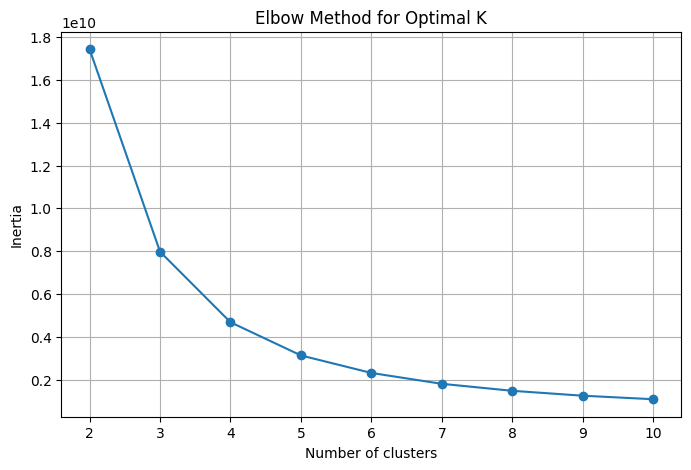

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

features_for_clustering = df.copy()

inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [4]:

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_for_clustering)

cluster_profile = df.groupby('Cluster').mean()
print(cluster_profile)

         Flight Number  Day of Operation  STA (Standard Time of Arrival)  \
Cluster                                                                    
0            -0.005304          2.985941                      243.243631   
1             0.000756          3.004513                      723.542551   
2             0.004630          3.010689                     1201.466664   

         ETA (Estimated Time of Arrival)  ATA (Actual Time of Arrival)  \
Cluster                                                                  
0                             270.825934                    315.994331   
1                             751.468464                    798.525301   
2                            1229.871143                   1278.442320   

         ETD (Estimated Time of Departure)  ATD (Actual Time of Departure)  \
Cluster                                                                      
0                               365.047769                      382.948018   
1             

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_clean = df.copy()

if 'Passenger Mishandling Probability (%)' in df_clean.columns:
    df_clean = df_clean.drop(columns=['Passenger Mishandling Probability (%)'])

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df_clean)

X = df_clean.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

max_len = 64
X_pad = np.zeros((X.shape[0], max_len))
X_pad[:, :X.shape[1]] = X

X_reshaped = X_pad.reshape(-1, 8, 8, 1)
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, labels, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(k, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9139 - loss: 0.2211 - val_accuracy: 0.9675 - val_loss: 0.0807
Epoch 2/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9892 - loss: 0.0275 - val_accuracy: 0.9947 - val_loss: 0.0140
Epoch 3/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9945 - loss: 0.0154 - val_accuracy: 0.9906 - val_loss: 0.0236
Epoch 4/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9961 - loss: 0.0113 - val_accuracy: 0.9974 - val_loss: 0.0076
Epoch 5/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9963 - loss: 0.0096 - val_accuracy: 0.9985 - val_loss: 0.0040
Epoch 6/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9971 - loss: 0.0082 - val_accuracy: 0.9943 - val_loss: 0.0146
Epoch 7/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9973 - loss: 0.0077 - val_accuracy: 0.9836 - val_loss: 0.0495
Epoch 8/20
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9969 - loss: 0.0087

In [6]:
delay_threshold = 30
df['Delay_Label'] = (
    (df['Arrival Delay (mins)'] > delay_threshold) |
    (df['Departure Delay (mins)'] > delay_threshold)
).astype(int)


In [7]:
X = df.drop(columns=[
    'Delay_Label',
    'Arrival Delay (mins)', 'Departure Delay (mins)',
    'Passenger Mishandling Probability (%)',
    'Flight Number', 'Seat Number', 'Sequence Number (Checked-in)'
])
y = df['Delay_Label']


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

X_processed = preprocessor.fit_transform(X)

In [10]:
import numpy as np

max_len = 64
X_padded = np.zeros((X_processed.shape[0], max_len))
X_padded[:, :X_processed.shape[1]] = X_processed

X_cnn = X_padded.reshape(-1, 8, 8, 1)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)


In [12]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(8, 8, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)

Epoch 1/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9977 - loss: 0.0213 - val_accuracy: 1.0000 - val_loss: 4.3661e-09
Epoch 2/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 3.0650e-08 - val_accuracy: 1.0000 - val_loss: 3.9855e-10
Epoch 3/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 4.6425e-09 - val_accuracy: 1.0000 - val_loss: 1.0410e-10
Epoch 4/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 1.0000 - loss: 2.4664e-09 - val_accuracy: 1.0000 - val_loss: 2.9709e-11
Epoch 5/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 1.0000 - loss: 1.2328e-09 - val_accuracy: 1.0000 - val_loss: 1.2990e-11
Epoch 6/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 5.8909e-10 - val_accuracy: 1.0000 - val_loss: 7.0077e-12
Epoch 7/25
1948/1948 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 1.0000 - loss: 3.1309e-10 - val_accuracy: 1.0000 - val_loss: 4.4902e-12
Epoch 8/25
1948/1948 ━━━━━━━━━━━━━━━

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

487/487 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 4.2587e-15
Test Accuracy: 1.0


In [19]:
sample = X_test[0].reshape(1, 8, 8, 1)
prediction = model.predict(sample)
print("Delayed" if prediction[0][0] > 0.5 else "On-time")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
On-time


In [22]:
!pip install tensorflow

In [36]:
# Encoder
encoder_inputs = Input(shape=input_shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Lambda(sampling, name="z")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(2 * 4 * 4, activation='relu')(decoder_inputs)
x = Reshape((4, 4, 2))(x)
x = Conv2DTranspose(8, (3, 3), strides=2, activation='relu', padding='same')(x)
decoder_outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_inputs, decoder_outputs, name="decoder")


In [37]:
class VAEWithLoss(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEWithLoss, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        reconstruction_loss = tf.keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(reconstructed))
        reconstruction_loss *= input_shape[0] * input_shape[1]

        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        total_loss = K.mean(reconstruction_loss + kl_loss)

        self.add_loss(total_loss)
        self.loss_tracker.update_state(total_loss)
        return reconstructed

    @property
    def metrics(self):
        return [self.loss_tracker]


In [39]:
vae = VAEWithLoss(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(X_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: -68.6389 - val_loss: -69.5013
Epoch 2/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: -69.8402 - val_loss: -71.1242
Epoch 3/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: -70.0957 - val_loss: -72.1317
Epoch 4/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: -71.5460 - val_loss: -72.9137
Epoch 5/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: -72.6298 - val_loss: -73.4540
Epoch 6/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: -72.7745 - val_loss: -74.2154
Epoch 7/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: -74.0318 - val_loss: -74.7731
Epoch 8/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: -74.6583 - val_loss: -75.4564
Epoch 9/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: -75.4585 - val_loss: -76.3250
Epoch 10/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: -76.1726 - val_loss: -76.9047
Epoch 11/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: -76.8634 - va

487/487 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


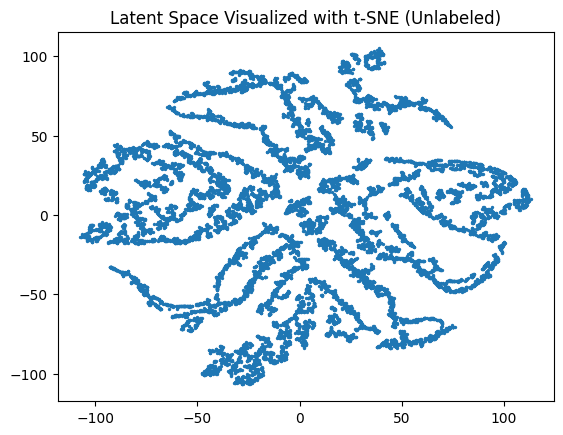

In [41]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

z_mean, _, _ = encoder.predict(X_test, batch_size=32)
z_tsne = TSNE(n_components=2).fit_transform(z_mean)

plt.scatter(z_tsne[:, 0], z_tsne[:, 1], s=2)
plt.title("Latent Space Visualized with t-SNE (Unlabeled)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


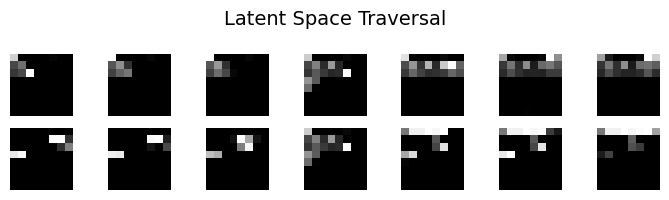

In [42]:
def latent_traversal(decoder, latent_dim, steps=7):
    z = np.zeros((1, latent_dim))
    fig, axes = plt.subplots(latent_dim, steps, figsize=(steps, latent_dim))

    for dim in range(latent_dim):
        for i, val in enumerate(np.linspace(-3, 3, steps)):
            z_copy = np.copy(z)
            z_copy[0, dim] = val
            img = decoder.predict(z_copy)[0].reshape(8, 8)
            axes[dim, i].imshow(img, cmap='gray')
            axes[dim, i].axis("off")

    plt.suptitle("Latent Space Traversal", fontsize=14)
    plt.tight_layout()
    plt.show()

latent_traversal(decoder, latent_dim=2)
